# Template matching

In [21]:
# Analyzing a new photometry trace using template matching

#import libraries and files
import pandas as pd
import operator
import cv2
import csv
import math
import matplotlib.pyplot as plt  # standard Python plotting library
import numpy as np  # package for scientific computing, handles arrays and math
import matplotlib.gridspec as gs
from scipy.optimize import curve_fit
import seaborn as sns
from tdt import read_block

baseline_start = 0 # in seconds
baseline_end = 600 #in seconds
dF_F_outlier = 50

#photometry path and file
FOLDER_PATH = 'D:/Bruchas_lab/Lab_photometry/Li_fear_box_triggered-220602-095047/'

FOLDER_NAME = '159459-L-221020-102241'
BLOCK_PATH = FOLDER_PATH + FOLDER_NAME
VIDEO_PATH = BLOCK_PATH+'/'+'Li_photo_stim_1_camera_-220601-092827_159459-L-221020-102241_Cam1.avi'

#Behavior Deeplabcut file
BEHAVE_PATH = 'D:/Bruchas_lab/Lab_DLC/'
BEHAVE_NAME = 'Li_photo_stim_1_camera_-220601-092827_159459-L-221020-102241_Cam1DLC_resnet50_Anesthesia_simplified_2Apr4shuffle1_300000.csv'

print("Folder: ", FOLDER_NAME)
print("\033[1m"+"Importing photometry data..."+"\033[0m")
data = read_block(BLOCK_PATH)

#Define sample size and frequency
data_470 = data.streams._470A.data
data_405 = data.streams._405A.data
size_470 = len(data_470)
size_405 = len(data_405) #isosbestic channel
freq_470 = data.streams._470A.fs #sampling frequency
print("470/405 sampling frequency: ", freq_470)
time_470 = np.linspace(1, size_470, size_470) / freq_470
total_time = time_470[size_470-1]
print("Total sampling time: ", total_time)
fit_window = size_470
print("Done.")

print("\033[1m"+"Normalizing photometry data..."+"\033[0m")
#Fit 405 nm trace to 470 nm by applying least-squares fit
#Linear least square fit
Sum_f = 0 #f is 405A
Sum_g = 0 #g is 470A
Sum_fg = 0 # fg is 405A*407A
Sum_fsq = 0 #fsq is f^2 or 405A^2
for i in range(fit_window):
    Sum_f = Sum_f + data_405[i]
    Sum_g = Sum_g + data_470[i]
    Sum_fg = Sum_fg + data_405[i]*data_470[i]
    Sum_fsq = Sum_fsq + (data_405[i])*(data_405[i])
#end for i

#Slope*x + Intercept = y
Slope = (Sum_f*Sum_g - size_470*Sum_fg)/(Sum_f*Sum_f - size_470*Sum_fsq)
Intercept = (Sum_g*Sum_fsq - Sum_f*Sum_fg)/(size_470*Sum_fsq - Sum_f*Sum_f)
print("Least squares fit: y = ", Slope, "*x + ", Intercept)

#initialize fit
Fit_405 = [0 for i in range(size_470)]
dF_F = [0 for i in range(size_470)]
for i in range(size_470):
    Fit_405[i] = Slope*data_405[i] + Intercept
    dF_F[i] = (data_470[i] - Fit_405[i])*100/Fit_405[i]
#end for i
print("Done.")

#Curate
print("\033[1m"+"Removing outlier..."+"\033[0m")
count = 0
for i in range(size_470):
    if abs(dF_F[i])>dF_F_outlier:
        dF_F[i] = np.NaN
        count = count + 1
    #endif
#end for i
print("Number of outliers changed to NaN: ", count)
print("Done.")

#Delete beginning poor signal
for i in range(int(freq_470*0.5)):
    dF_F[i]=np.NaN
#endfor i

#Z-scoring
print("\033[1m"+"Z-scoring..."+"\033[0m")
avg_F = np.nanmean(dF_F[int(baseline_start*freq_470):int(baseline_end*freq_470)])
std_F = np.nanstd(dF_F[int(baseline_start*freq_470):int(baseline_end*freq_470)])
for i in range(size_470):
     dF_F[i] = (dF_F[i] - avg_F)/std_F
#end for i

print("Done.")   


Folder:  159459-L-221020-102241
Importing photometry data...
read from t=0s to t=3182.84s
470/405 sampling frequency:  1017.2526245117188
Total sampling time:  3182.8475267430495
Done.
Normalizing photometry data...
Least squares fit: y =  1.2006666730904927 *x +  -37.02892903540114
Done.
Removing outlier...
Number of outliers changed to NaN:  224
Done.
Z-scoring...
Done.


In [13]:
#Load prior saved data from analysis above
event_times=np.load("Archived_figs/20220118_event_init.npy")
event2_times=np.load("Archived_figs/20220118_event_arrest.npy")
behave_time = np.load("Archived_figs/20220118_behave_time.npy")
marker_dist=np.load("Archived_figs/20220118_dist_markers.npy")
movement_bin = np.load("Archived_figs/20220118_movement_bin.npy")
all_movement_bin = np.load("Archived_figs/20220118_all_movement_bin.npy")
print("Loaded")

Loaded


# Arrest to Movement Template Matching

template:  3255
dF:  305175
sig 1:  326
sig 2:  30518
Corr len: 30192
peaks:  103
delay:  -236.7905835041883


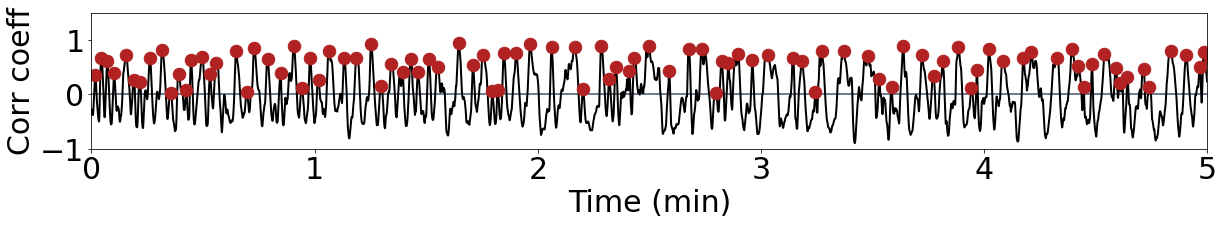

In [22]:
#Using Pearson's r (scale invariant) to detect matches to template

import numpy as np
import scipy.stats  

analysis_window = [2.5,0.7]
hi_cutoff = 300
template = np.load("Archived_figs/20220118_init_template_2_5_0_7.npy") #Arrest to movement template
dF_data = dF_F[0:int(hi_cutoff*freq_470)]
corr_coeff = []
print("template: ", len(template))
print("dF: ", len(dF_data))

sig1 = np.nan_to_num(template[::10])
temp_size = len(sig1)
sig2 = np.nan_to_num(dF_data[::10])
print("sig 1: ", len(sig1))
print("sig 2: ", len(sig2))

scales = [1]
corr_coeff_scaled = []
for j in range(len(scales)):
    sig1_scaled = [x*scales[j] for x in sig1]
    corr_coeff = []
    for i in range(len(sig2)-temp_size):
        temp = scipy.stats.pearsonr(sig1_scaled, sig2[i:i+temp_size])
        corr_coeff.append(temp[0])
    #endfor i
    corr_coeff_scaled.append(corr_coeff)
#endfor j

corr_coeff_scaled = np.transpose(np.asarray(corr_coeff_scaled))
print("Corr len:", len(corr_coeff_scaled))

#convert to array
corr_coeff = []
for j in range(len(corr_coeff_scaled)):
    corr_coeff.append(np.nanmax(corr_coeff_scaled[j]))
#endfor j
corr_coeff=np.asarray(corr_coeff)

#Find peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(corr_coeff, distance=100, prominence=0.25)
event3_times = []
print("peaks: ", len(peaks))

temp = time_470[0:int(hi_cutoff*freq_470)]
temp = temp[::10]
temp = temp[:-temp_size]
print("delay: ", 60-temp[-1])
time_data = [x+analysis_window[0] for x in temp]

for i in range(len(peaks)):
    event3_times.append(time_data[peaks[i]])
#endfor i

#Cutoff for peak detection
pruned_peaks=[]
corr_cutoff=0
for j in range(len(peaks)):
    if(corr_coeff[peaks[j]]>corr_cutoff):
        pruned_peaks.append(peaks[j])
    #endif
#endfor j

font_size = 30
xmin=0
xmax=5
xint=1
ymin_2=-1
ymax_2=1.5
yint_2=1
plot_width_2 = 20
plot_height_2 = 2.5

pruned_peaks_min = [x/6000 for x in pruned_peaks]
time_min = []
for i in range(len(corr_coeff)):
    time_min.append(i/6000)
#endfor i

fig,(ax2) = plt.subplots(nrows=1, ncols=1, figsize=(plot_width_2, plot_height_2))
ax2.axhline(corr_cutoff, color='slategray', linewidth=2)
ax2.plot(time_min,corr_coeff, color='black', linewidth=2)
ax2.plot(pruned_peaks_min, corr_coeff[pruned_peaks], ".", markersize=25, color='firebrick')
ax2.set_ylabel('Corr coeff', fontsize=font_size)
ax2.set_xlabel('Time (min)', fontsize=font_size)
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin_2,ymax_2)
plt.xticks(np.arange(xmin, xmax+0.01, xint))
plt.yticks(np.arange(ymin_2, ymax_2+0.01, yint_2))
plt.show()

event3_times=[]
for i in range(len(pruned_peaks)):
    event3_times.append(time_data[pruned_peaks[i]])
#endfor i

In [35]:
#Movement pixel displacement associated with template-matched photometry events
pre_window_size = 5 # in second
post_window_size = 10 # in second
behave_interval_time = []
activity_interval_time = []
behave_interval_time.append(behave_time[0:int((pre_window_size+post_window_size)*frate)]) #behave_time
activity_interval=int((pre_window_size+post_window_size)*freq_470) #calculate activity interval
activity_interval_time.append(time_470[0:activity_interval]) #activity_time
behave_interval_time[0] = [i - pre_window_size for i in behave_interval_time[0]] #re-align to 0
activity_interval_time[0] = [i - pre_window_size for i in activity_interval_time[0]] #realign to 0


behave_mean3_marker1_array = []
activity_mean3_array = []
behave_data3_marker1 = []
activity_data3=[]

for j in range(len(event3_times)):
    if(event3_times[j]-pre_window_size>0 and event3_times[j]+post_window_size<behave_time[-1]):
        activity_data3.append(np.around(dF_F[int((event3_times[j]-pre_window_size)*freq_470):int((event3_times[j]+post_window_size)*freq_470-1)],2))
        behave_data3_marker1.append(marker_dist[0][int((event3_times[j]-pre_window_size)*frate):int((event3_times[j]+post_window_size)*frate)])
    #endif
#endfor j
print("\033[1m"+"Re-format data..."+"\033[0m")
behave_mean3_marker1=[]
behave_std3_marker1=[]
behave_data3_transposed_marker1 = np.transpose(np.array(behave_data3_marker1))
for i in range(len(behave_data3_transposed_marker1)):    
    behave_mean3_marker1.append(np.nanmean(behave_data3_transposed_marker1[i]))
    behave_std3_marker1.append(np.nanstd(behave_data3_transposed_marker1[i]))
#end for i
                
behave_mean3_marker1_array = behave_mean3_marker1
behave_std3_marker1_array = behave_std3_marker1
  
print("Behave mean 3: ", len(behave_mean3_marker1))
        
activity_mean3=[]
activity_std3=[]
activity_data3_transposed=np.transpose(np.array(activity_data3))
for i in range(len(activity_data3_transposed)):    
    activity_mean3.append(np.nanmean(activity_data3_transposed[i]))
    activity_std3.append(np.nanstd(activity_data3_transposed[i]))            
#end for i
    
activity_mean3_array = activity_mean3
activity_std3_array = activity_std3

print("Activity mean 3: ", len(activity_mean3))
 

Re-format data...
Behave mean 3:  150
Activity mean 3:  15258


Plot behavior (arrest to movement)...


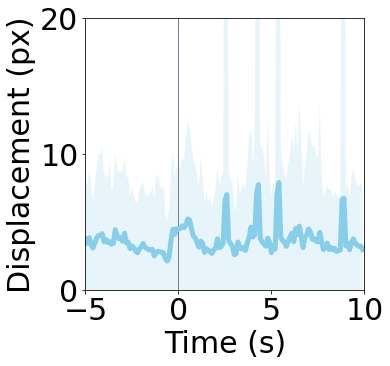

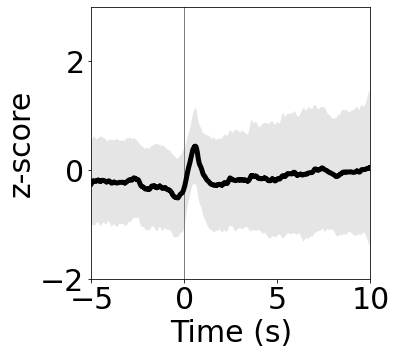

In [36]:
#Plots for movement pixel displacement associated with template-matched photometry events

import numpy as np  # package for scientific computing, handles arrays and math
from operator import add
#Plot behavior, activity events

#User defined parameters
font_size = 30
plot_width = 5
plot_height = 5
xint = 5
ymax_4 = 20
ymin_5 = -2
ymax_5 = 3
j=0

#Arrest to Movement
print("\033[1m"+"Plot behavior (arrest to movement)..."+"\033[0m")
temp_array=[]
temp_transposed_array=[]
fig,ax4 = plt.subplots(nrows=1, ncols=1, figsize=(plot_width, plot_height))
behave_mean_array=behave_mean3_marker1_array #add two markers together
behave_std_array = behave_std3_marker1_array
ax4.axvline(0, color='slategray', linewidth=1)
ax4.plot(behave_interval_time[0],behave_mean_array, color='skyblue', linewidth=5)
ax4.fill_between(behave_interval_time[0], list(map(operator.add,behave_mean_array,behave_std_array)), list(map(operator.sub,behave_mean_array,behave_std_array)), facecolor='skyblue', alpha=0.2)
ax4.set_ylabel('Displacement (px)', fontsize=font_size)
ax4.set_xlabel('Time (s)', fontsize=font_size)
ax4.tick_params(axis="x", labelsize=font_size)
ax4.tick_params(axis="y", labelsize=font_size)
ax4.set_ylim(0,ymax_4)
ax4.set_xlim(-1*pre_window_size,post_window_size)
plt.yticks(np.arange(0, ymax_4+0.01, 10))
plt.xticks(np.arange(-1*pre_window_size, post_window_size+0.01, xint))
#plt.savefig("20230302_LC_behavior_init_"+str(pause_interval)+"s_"+str(pause_threshold)+"px_HEAD_predicted.pdf",bbox_inches = 'tight',dpi=300)
plt.show()

fig,ax6 = plt.subplots(nrows=1, ncols=1, figsize=(plot_width, plot_height))
ax6.axvline(0, color='slategray', linewidth=1)
ax6.plot(activity_interval_time[0],activity_mean3_array, color='black', linewidth=5)
ax6.fill_between(activity_interval_time[0], list(map(operator.add,activity_mean3_array,activity_std3_array)), list(map(operator.sub,activity_mean3_array,activity_std3_array)), facecolor='gray', alpha=0.2)
ax6.set_ylabel('z-score', fontsize=font_size)
ax6.set_xlabel('Time (s)', fontsize=font_size)
#ax6.axvline(0, color='slategray', linewidth=3)
#ax6.axhline(0, color='slategray', linewidth=3)
ax6.tick_params(axis="x", labelsize=font_size)
ax6.tick_params(axis="y", labelsize=font_size)
ax6.set_ylim(ymin_5,ymax_5)
ax6.set_xlim(-1*pre_window_size,post_window_size)
plt.yticks(np.arange(ymin_5, ymax_5+0.01, 2))
plt.xticks(np.arange(-1*pre_window_size, post_window_size+0.01, xint))
#plt.savefig("20230302_LC_activity_init_"+str(pause_interval)+"s_"+str(pause_threshold)+"px_predicted.pdf",bbox_inches = 'tight',dpi=300)
plt.show()


delay:  -236.7905835041883


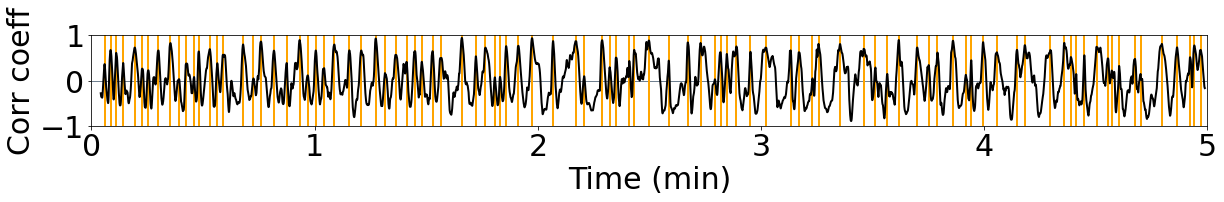

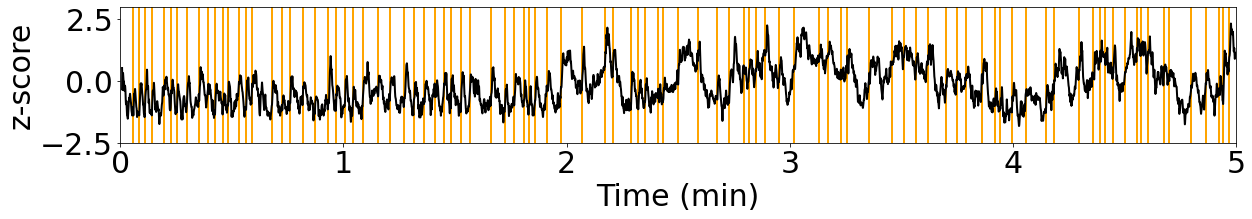

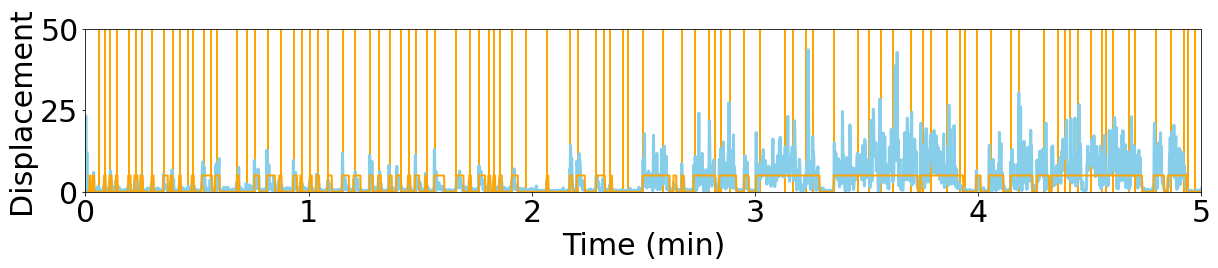

In [16]:
#All template-detected events along the photometry trace

#User defined plot parameters
plot_width_2 = 20
plot_height_2 = 2.5
xmin=0
xmax=5
xint=1
ymin_2=-1
ymax_2=1
yint_2=1

temp = time_470[0:int(hi_cutoff*freq_470)]
temp = temp[::10]
temp = temp[:-temp_size]
print("delay: ", 60-temp[-1])
time_data = [x+analysis_window[0] for x in temp]
time_data_min = [x/60 for x in time_data]
scaled_movement_bin = [1*x/10-1 for x in all_movement_bin]
event3_times_min = [x/60 for x in event3_times]

fig,(ax2) = plt.subplots(nrows=1, ncols=1, figsize=(plot_width_2, plot_height_2*2/3))
ax2.axhline(0, color='slategray', linewidth=1)
for i in range(len(event3_times_min)):
    ax2.axvline(event3_times_min[i], color='orange',linewidth=2)
#endfor i
#ax2.plot(time_data_min, corr_coeff[pruned_peaks], ".", markersize=10, color='firebrick')
ax2.plot(time_data_min, corr_coeff, color='black', linewidth=2)
#ax2.plot(behave_time_min, scaled_movement_bin, color='orange',linewidth=4)
ax2.set_ylabel('Corr coeff', fontsize=font_size)
ax2.set_xlabel('Time (min)', fontsize=font_size)
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
#ax2.axes.get_xaxis().set_visible(False)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin_2,ymax_2)
plt.xticks(np.arange(xmin, xmax+0.01, xint))
plt.yticks(np.arange(ymin_2, ymax_2+0.01, yint_2))
#plt.savefig("20230302_crosscorrelate_graph_ALL.pdf",bbox_inches = 'tight',dpi=300)
plt.show()

#User defined plot parameters
plot_width_2 = 20
plot_height_2 = 2.5
ymin_2=-2.5
ymax_2=3
yint_2=2.5

scaled_movement_bin = [5*x/10-5 for x in all_movement_bin]
time_470_min = [x/60 for x in time_470]
behave_time_min = [x/60 for x in behave_time]
event3_times_min = [x/60 for x in event3_times]

fig,(ax2) = plt.subplots(nrows=1, ncols=1, figsize=(plot_width_2, plot_height_2))
for i in range(len(event3_times_min)):
    ax2.axvline(event3_times_min[i], color='orange',linewidth=2)
#endfor i
ax2.plot(time_470_min[::10], dF_F[::10], color='black', linewidth=2)
#ax2.plot(behave_time_min, scaled_movement_bin, color='orange',linewidth=4)
ax2.set_ylabel('z-score', fontsize=font_size)
ax2.set_xlabel('Time (min)', fontsize=font_size)
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
#ax2.axes.get_xaxis().set_visible(False)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin_2,ymax_2)
plt.xticks(np.arange(xmin, xmax+0.01, xint))
plt.yticks(np.arange(ymin_2, ymax_2+0.01, yint_2))
#plt.savefig("20230302_crosscorrelate_photometry_ALL.pdf",bbox_inches = 'tight',dpi=300)
plt.show()

#User defined plot parameters
plot_width_2 = 20
plot_height_2 = 3
ymin_2=0
ymax_2=50
yint_2=25

scaled_movement_bin = [x for x in all_movement_bin]

fig,(ax2) = plt.subplots(nrows=1, ncols=1, figsize=(plot_width_2, plot_height_2))
for i in range(len(event3_times_min)):
    ax2.axvline(event3_times_min[i], color='orange',linewidth=2)
#endfor i
ax2.plot(behave_time_min, marker_dist[0], color='skyblue',linewidth=3)
ax2.plot(behave_time_min, scaled_movement_bin, color='orange',linewidth=2)
ax2.set_ylabel('Displacement', fontsize=font_size)
ax2.set_xlabel('Time (min)', fontsize=font_size)
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
#ax2.axes.get_xaxis().set_visible(False)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin_2,ymax_2)
plt.xticks(np.arange(xmin, xmax+0.01, xint))
plt.yticks(np.arange(ymin_2, ymax_2+0.01, yint_2))
#plt.savefig("20230302_crosscorrelate_behavior_ALL.pdf",bbox_inches = 'tight',dpi=300)
plt.show()


# Movement to Arrest Template Matching

template:  3560
dF:  305175
sig 1:  356
sig 2:  30518
Corr len: 30162
peaks:  93
delay:  -236.4956715100866


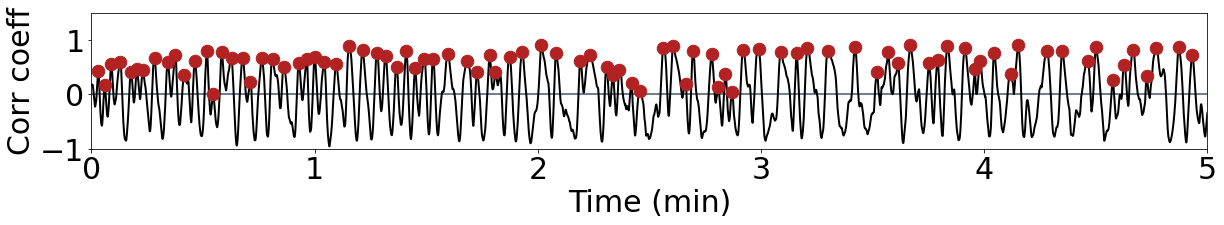

In [37]:
#Using Pearson's r (scale invariant) to detect matches to template

import numpy as np
import scipy.stats  

analysis_window = [1.5,2.0]
hi_cutoff = 300
template = np.load("Archived_figs/20220118_arrest_template_1_5_2_0.npy") #Movement to arrest template
dF_data = dF_F[0:int(hi_cutoff*freq_470)]
corr_coeff = []
print("template: ", len(template))
print("dF: ", len(dF_data))

sig1 = np.nan_to_num(template[::10])
temp_size = len(sig1)
sig2 = np.nan_to_num(dF_data[::10])
print("sig 1: ", len(sig1))
print("sig 2: ", len(sig2))

scales = [1]
corr_coeff_scaled = []
for j in range(len(scales)):
    sig1_scaled = [x*scales[j] for x in sig1]
    corr_coeff = []
    for i in range(len(sig2)-temp_size):
        temp = scipy.stats.pearsonr(sig1_scaled, sig2[i:i+temp_size])
        corr_coeff.append(temp[0])
    #endfor i
    corr_coeff_scaled.append(corr_coeff)
#endfor j

corr_coeff_scaled = np.transpose(np.asarray(corr_coeff_scaled))
print("Corr len:", len(corr_coeff_scaled))

#convert to array
corr_coeff = []
for j in range(len(corr_coeff_scaled)):
    corr_coeff.append(np.nanmax(corr_coeff_scaled[j]))
#endfor j
corr_coeff=np.asarray(corr_coeff)

#Find peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(corr_coeff, distance=100, prominence=0.25)
event3_times = []
print("peaks: ", len(peaks))

temp = time_470[0:int(hi_cutoff*freq_470)]
temp = temp[::10]
temp = temp[:-temp_size]
print("delay: ", 60-temp[-1])
time_data = [x+analysis_window[0] for x in temp]

for i in range(len(peaks)):
    event3_times.append(time_data[peaks[i]])
#endfor i

#Cutoff for peak detection
pruned_peaks=[]
corr_cutoff=0
for j in range(len(peaks)):
    if(corr_coeff[peaks[j]]>corr_cutoff):
        pruned_peaks.append(peaks[j])
    #endif
#endfor j

xmin=0
xmax=5
xint=1
ymin_2=-1
ymax_2=1.5
yint_2=1

pruned_peaks_min = [x/6000 for x in pruned_peaks]
time_min = []
for i in range(len(corr_coeff)):
    time_min.append(i/6000)
#endfor i

fig,(ax2) = plt.subplots(nrows=1, ncols=1, figsize=(plot_width_2, plot_height_2))
ax2.axhline(corr_cutoff, color='slategray', linewidth=2)
ax2.plot(time_min,corr_coeff, color='black', linewidth=2)
ax2.plot(pruned_peaks_min, corr_coeff[pruned_peaks], ".", markersize=25, color='firebrick')
ax2.set_ylabel('Corr coeff', fontsize=font_size)
ax2.set_xlabel('Time (min)', fontsize=font_size)
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
#ax2.axes.get_xaxis().set_visible(False)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin_2,ymax_2)
plt.xticks(np.arange(xmin, xmax+0.01, xint))
plt.yticks(np.arange(ymin_2, ymax_2+0.01, yint_2))
#plt.savefig("20230302_photometry_template_crosscorrelate.pdf",bbox_inches = 'tight',dpi=300)
plt.show()

event3_times=[]
for i in range(len(pruned_peaks)):
    event3_times.append(time_data[pruned_peaks[i]])
#endfor i

In [38]:
#Movement pixel displacement associated with template-matched photometry events

behave_mean3_marker1_array = []
activity_mean3_array = []
behave_data3_marker1 = []
activity_data3=[]
behave_interval_time = []
activity_interval_time = []
behave_interval_time.append(behave_time[0:int((pre_window_size+post_window_size)*frate)]) #behave_time
activity_interval=int((pre_window_size+post_window_size)*freq_470) #calculate activity interval
activity_interval_time.append(time_470[0:activity_interval]) #activity_time
behave_interval_time[0] = [i - pre_window_size for i in behave_interval_time[0]] #re-align to 0
activity_interval_time[0] = [i - pre_window_size for i in activity_interval_time[0]] #realign to 0

for j in range(len(event3_times)):
    if(event3_times[j]-pre_window_size>0 and event3_times[j]+post_window_size<behave_time[-1]):
        activity_data3.append(np.around(dF_F[int((event3_times[j]-pre_window_size)*freq_470):int((event3_times[j]+post_window_size)*freq_470-1)],2))
        behave_data3_marker1.append(marker_dist[0][int((event3_times[j]-pre_window_size)*frate):int((event3_times[j]+post_window_size)*frate)])
    #endif
#endfor j
print("\033[1m"+"Re-format data..."+"\033[0m")
behave_mean3_marker1=[]
behave_std3_marker1=[]
behave_data3_transposed_marker1 = np.transpose(np.array(behave_data3_marker1))
for i in range(len(behave_data3_transposed_marker1)):    
    behave_mean3_marker1.append(np.nanmean(behave_data3_transposed_marker1[i]))
    behave_std3_marker1.append(np.nanstd(behave_data3_transposed_marker1[i]))
#end for i
                
behave_mean3_marker1_array = behave_mean3_marker1
behave_std3_marker1_array = behave_std3_marker1
  
print("Behave mean 3: ", len(behave_mean3_marker1))
        
activity_mean3=[]
activity_std3=[]
activity_data3_transposed=np.transpose(np.array(activity_data3))
for i in range(len(activity_data3_transposed)):    
    activity_mean3.append(np.nanmean(activity_data3_transposed[i]))
    activity_std3.append(np.nanstd(activity_data3_transposed[i]))            
#end for i
    
activity_mean3_array = activity_mean3
activity_std3_array = activity_std3

print("Activity mean 3: ", len(activity_mean3))
 

Re-format data...
Behave mean 3:  150
Activity mean 3:  15258


Plot behavior (arrest to movement)...


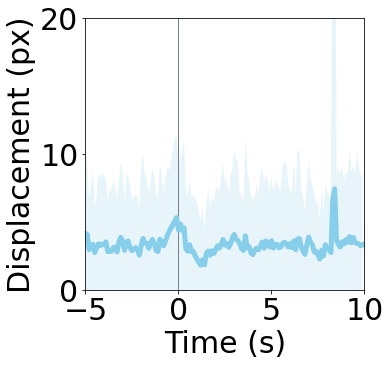

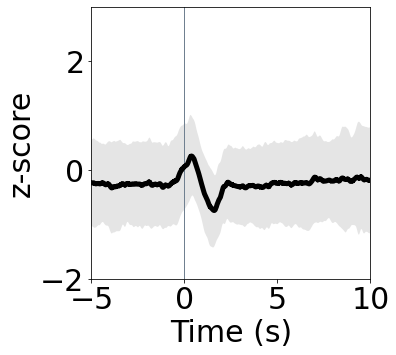

In [39]:
#Plots for movement pixel displacement associated with template-matched photometry events

import numpy as np  # package for scientific computing, handles arrays and math
from operator import add
#Plot behavior, activity events

#User defined parameters
font_size = 30
plot_width = 5
plot_height = 5
xint = 5
ymax_4 = 20
ymin_5 = -2
ymax_5 = 3
j=0

#Movement to arrest
#for i in range(len(behave_mean_marker1_array))

print("\033[1m"+"Plot behavior (arrest to movement)..."+"\033[0m")
#for j in range(len(behave_data)):
temp_array=[]
temp_transposed_array=[]
fig,ax4 = plt.subplots(nrows=1, ncols=1, figsize=(plot_width, plot_height))
behave_mean_array=behave_mean3_marker1_array #add two markers together
behave_std_array = behave_std3_marker1_array
ax4.axvline(0, color='slategray', linewidth=1)
ax4.plot(behave_interval_time[0],behave_mean_array, color='skyblue', linewidth=5)
ax4.fill_between(behave_interval_time[0], list(map(operator.add,behave_mean_array,behave_std_array)), list(map(operator.sub,behave_mean_array,behave_std_array)), facecolor='skyblue', alpha=0.2)
ax4.set_ylabel('Displacement (px)', fontsize=font_size)
ax4.set_xlabel('Time (s)', fontsize=font_size)
ax4.tick_params(axis="x", labelsize=font_size)
ax4.tick_params(axis="y", labelsize=font_size)
ax4.set_ylim(0,ymax_4)
ax4.set_xlim(-1*pre_window_size,post_window_size)
plt.yticks(np.arange(0, ymax_4+0.01, 10))
plt.xticks(np.arange(-1*pre_window_size, post_window_size+0.01, xint))
#plt.savefig("20230302_LC_behavior_arrest_"+str(pause_interval)+"s_"+str(pause_threshold)+"px_HEAD_predicted.pdf",bbox_inches = 'tight',dpi=300)
plt.show()

fig,ax6 = plt.subplots(nrows=1, ncols=1, figsize=(plot_width, plot_height))
ax6.axvline(0, color='slategray', linewidth=1)
ax6.plot(activity_interval_time[0],activity_mean3_array, color='black', linewidth=5)
ax6.fill_between(activity_interval_time[0], list(map(operator.add,activity_mean3_array,activity_std3_array)), list(map(operator.sub,activity_mean3_array,activity_std3_array)), facecolor='gray', alpha=0.2)
ax6.set_ylabel('z-score', fontsize=font_size)
ax6.set_xlabel('Time (s)', fontsize=font_size)
#ax6.axvline(0, color='slategray', linewidth=3)
#ax6.axhline(0, color='slategray', linewidth=3)
ax6.tick_params(axis="x", labelsize=font_size)
ax6.tick_params(axis="y", labelsize=font_size)
ax6.set_ylim(ymin_5,ymax_5)
ax6.set_xlim(-1*pre_window_size,post_window_size)
plt.yticks(np.arange(ymin_5, ymax_5+0.01, 2))
plt.xticks(np.arange(-1*pre_window_size, post_window_size+0.01, xint))
#plt.savefig("20230302_LC_activity_arrest_"+str(pause_interval)+"s_"+str(pause_threshold)+"px_predicted.pdf",bbox_inches = 'tight',dpi=300)
plt.show()


delay:  -236.4956715100866


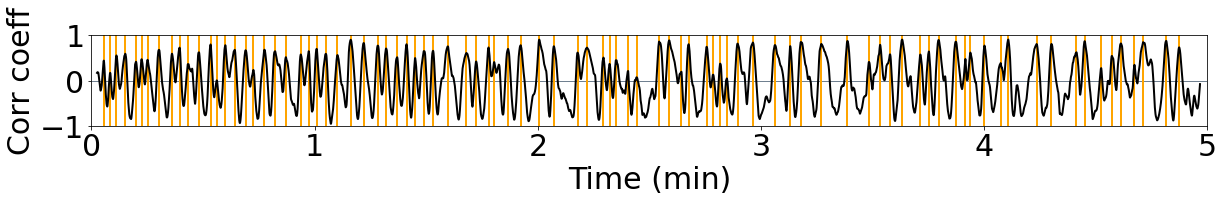

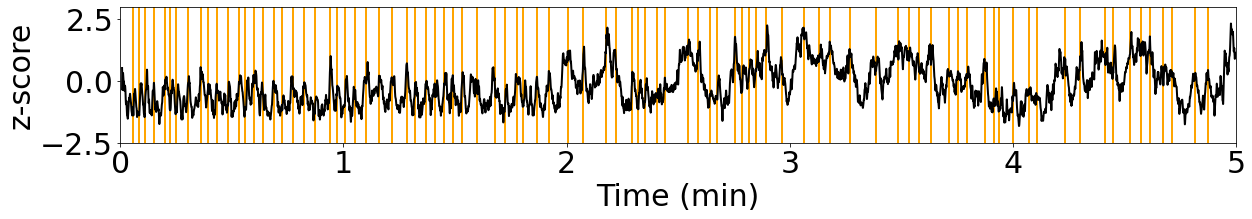

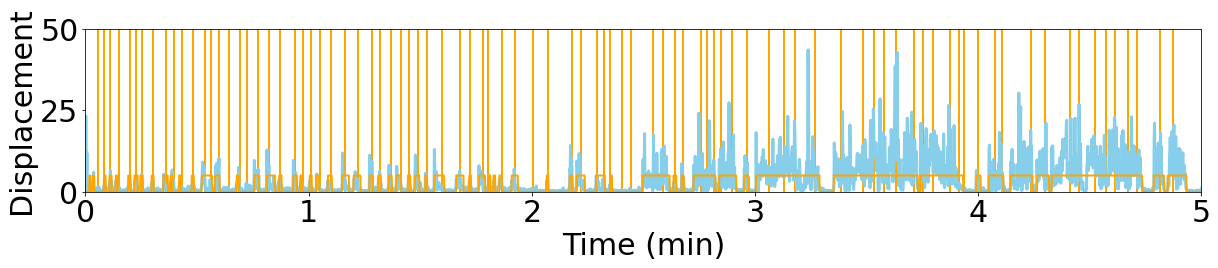

In [139]:
#All template-detected events along the photometry trace

#User defined plot parameters
plot_width_2 = 20
plot_height_2 = 2.5
xmin=0
xmax=5
xint=1
ymin_2=-1
ymax_2=1
yint_2=1

temp = time_470[0:int(hi_cutoff*freq_470)]
temp = temp[::10]
temp = temp[:-temp_size]
print("delay: ", 60-temp[-1])
time_data = [x+analysis_window[0] for x in temp]
time_data_min = [x/60 for x in time_data]
scaled_movement_bin = [1*x/10-1 for x in all_movement_bin]
event3_times_min = [x/60 for x in event3_times]

fig,(ax2) = plt.subplots(nrows=1, ncols=1, figsize=(plot_width_2, plot_height_2*2/3))
ax2.axhline(0, color='slategray', linewidth=1)
for i in range(len(event3_times_min)):
    ax2.axvline(event3_times_min[i], color='orange',linewidth=2)
#endfor i
#ax2.plot(time_data_min, corr_coeff[pruned_peaks], ".", markersize=10, color='firebrick')
ax2.plot(time_data_min, corr_coeff, color='black', linewidth=2)
#ax2.plot(behave_time_min, scaled_movement_bin, color='orange',linewidth=4)
ax2.set_ylabel('Corr coeff', fontsize=font_size)
ax2.set_xlabel('Time (min)', fontsize=font_size)
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
#ax2.axes.get_xaxis().set_visible(False)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin_2,ymax_2)
plt.xticks(np.arange(xmin, xmax+0.01, xint))
plt.yticks(np.arange(ymin_2, ymax_2+0.01, yint_2))
#plt.savefig("20230302_crosscorrelate_graph_arrest_ALL.pdf",bbox_inches = 'tight',dpi=300)
plt.show()

#User defined plot parameters
plot_width_2 = 20
plot_height_2 = 2.5
ymin_2=-2.5
ymax_2=3
yint_2=2.5

scaled_movement_bin = [5*x/10-5 for x in all_movement_bin]
time_470_min = [x/60 for x in time_470]
behave_time_min = [x/60 for x in behave_time]
event3_times_min = [x/60 for x in event3_times]

fig,(ax2) = plt.subplots(nrows=1, ncols=1, figsize=(plot_width_2, plot_height_2))
for i in range(len(event3_times_min)):
    ax2.axvline(event3_times_min[i], color='orange',linewidth=2)
#endfor i
ax2.plot(time_470_min[::10], dF_F[::10], color='black', linewidth=2)
#ax2.plot(behave_time_min, scaled_movement_bin, color='orange',linewidth=4)
ax2.set_ylabel('z-score', fontsize=font_size)
ax2.set_xlabel('Time (min)', fontsize=font_size)
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
#ax2.axes.get_xaxis().set_visible(False)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin_2,ymax_2)
plt.xticks(np.arange(xmin, xmax+0.01, xint))
plt.yticks(np.arange(ymin_2, ymax_2+0.01, yint_2))
#plt.savefig("20230302_crosscorrelate_photometry_arrest_ALL.pdf",bbox_inches = 'tight',dpi=300)
plt.show()

#User defined plot parameters
plot_width_2 = 20
plot_height_2 = 3
ymin_2=0
ymax_2=50
yint_2=25

scaled_movement_bin = [x for x in all_movement_bin]

fig,(ax2) = plt.subplots(nrows=1, ncols=1, figsize=(plot_width_2, plot_height_2))
for i in range(len(event3_times_min)):
    ax2.axvline(event3_times_min[i], color='orange',linewidth=2)
#endfor i
ax2.plot(behave_time_min, marker_dist[0], color='skyblue',linewidth=3)
ax2.plot(behave_time_min, scaled_movement_bin, color='orange',linewidth=2)
ax2.set_ylabel('Displacement', fontsize=font_size)
ax2.set_xlabel('Time (min)', fontsize=font_size)
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
#ax2.axes.get_xaxis().set_visible(False)
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin_2,ymax_2)
plt.xticks(np.arange(xmin, xmax+0.01, xint))
plt.yticks(np.arange(ymin_2, ymax_2+0.01, yint_2))
#plt.savefig("20230302_crosscorrelate_behavior_arrest_ALL.pdf",bbox_inches = 'tight',dpi=300)
plt.show()

# Additional analyses between movement transitions & photometry signals

In [150]:
all_movement_bin = np.load("Archived_figs/20220118_all_movement_bin.npy")

# Arrest to movement template-matched events

In [41]:
#Detect closest neighbor from a photometry templated-matched event and a movement transition
diff = 0.5

bin_pos = 0
bin_events = []
for i in range(len(all_movement_bin)):
    if(all_movement_bin[i]>0):
        if(bin_pos==0):
            bin_pos=1
            bin_events.append(i/10)
    else:
        bin_pos=0
    #endif
#endfor i
print("binary events:", bin_events)
print("movement events:", np.round(event3_times,1))

#find nearest neighbor
count=0
for i in range(len(event3_times)):
    for j in range(len(bin_events)):
        if(abs(event3_times[i]-bin_events[j])<diff):
            count=count+1
            break
        #endif
    #endfor j
#endfor i
print("Total real events: ", len(bin_events), "Total predicted events: ", len(event3_times), "Count:", count) 


binary events: [1.1, 1.9, 5.0, 6.5, 8.2, 11.5, 13.2, 14.9, 17.8, 21.0, 22.9, 25.2, 28.6, 31.3, 34.9, 40.7, 45.4, 48.8, 52.1, 55.9, 57.8, 60.3, 62.1, 65.2, 69.0, 72.1, 76.4, 78.7, 81.6, 83.6, 86.7, 88.6, 91.4, 93.8, 99.7, 103.2, 105.8, 108.3, 109.7, 111.3, 114.6, 124.0, 130.2, 132.1, 137.3, 141.1, 149.8, 158.1, 160.3, 163.5, 170.4, 177.1, 180.3, 201.2, 224.5, 239.5, 242.9, 248.7, 255.8, 259.8, 287.2, 291.0]
movement events: [  3.3   5.    6.7   9.1  12.   13.5  15.1  18.2  21.7  23.7  25.9  28.9
  32.   33.7  36.   38.5  41.4  43.5  46.5  49.4  52.3  56.3  58.4  60.5
  63.   66.1  69.7  73.2  77.   79.2  82.2  84.7  87.   89.4  91.8  95.8
 100.8 103.4 106.7 108.3 112.  115.4 120.4 124.3 130.7 133.2 137.6 139.3
 141.  144.2 146.5 152.6 155.3 158.6 160.5 165.4 167.1 169.  170.8 173.7
 177.8 183.7 187.8 190.7 196.2 203.2 209.  212.  214.7 217.9 222.8 225.1
 227.7 232.3 234.9 236.3 240.1 244.4 246.4 254.1 258.1 264.8 267.  271.4
 274.3 276.7 280.4 282.7 288.9 292.4]
Total real events:  62 T

In [155]:
#Calculate how close are the photometry template-matched event to a movement transition event (temporal proximity) 

import pandas as pd

min_dist = []
for i in range(len(event3_times)):
    temp=np.NaN
    for j in range(len(bin_events)):
        if(j==1):
            temp = abs(event3_times[i]-bin_events[j])
        else:
            if(abs(event3_times[i]-bin_events[j])<temp):
                temp=abs(event3_times[i]-bin_events[j])
            #endif
        #endif
    #endfor j
    min_dist.append(np.round(temp,1))
#endfor i

print("Min dist: ", min_dist)
df=pd.DataFrame(min_dist)
df.to_csv('min_dist.csv', header=False)

Min dist:  [1.4, 0.0, 0.2, 0.9, 0.5, 0.3, 0.2, 0.4, 0.7, 0.8, 0.7, 0.3, 0.7, 1.2, 1.1, 2.2, 0.7, 1.9, 1.1, 0.6, 0.2, 0.4, 0.6, 0.2, 0.9, 0.9, 0.7, 1.1, 0.6, 0.5, 0.6, 1.1, 0.3, 0.8, 0.4, 2.0, 1.1, 0.2, 0.9, 0.0, 0.7, 0.8, 3.6, 0.3, 0.5, 1.1, 0.3, 1.8, 0.1, 3.1, 3.3, 2.8, 2.8, 0.5, 0.2, 1.9, 3.3, 1.4, 0.4, 3.3, 0.7, 3.4, 7.5, 10.4, 5.0, 2.0, 7.8, 10.8, 9.8, 6.6, 1.7, 0.6, 3.2, 7.2, 4.6, 3.2, 0.6, 1.5, 2.3, 1.7, 1.7, 5.0, 7.2, 11.6, 12.9, 10.5, 6.8, 4.5, 1.7, 1.4]


In [47]:
import numpy as np
import scipy.stats  

corr_cutoff=0

analysis_window = [2.5,0.7]
hi_cutoff = 300
template = np.load("Archived_figs/20220118_init_template_2_5_0_7.npy")
dF_data = dF_F[0:int(hi_cutoff*freq_470)]
corr_coeff = []
print("template: ", len(template))
print("dF: ", len(dF_data))

sig1 = np.nan_to_num(template[::10])
temp_size = len(sig1)
sig2 = np.nan_to_num(dF_data[::10])
print("sig 1: ", len(sig1))
print("sig 2: ", len(sig2))

scales = [1]
corr_coeff_scaled = []
for j in range(len(scales)):
    sig1_scaled = [x*scales[j] for x in sig1]
    corr_coeff = []
    for i in range(len(sig2)-temp_size):
        temp = scipy.stats.pearsonr(sig1_scaled, sig2[i:i+temp_size])
        corr_coeff.append(temp[0])
    #endfor i
    corr_coeff_scaled.append(corr_coeff)
#endfor j

corr_coeff_scaled = np.transpose(np.asarray(corr_coeff_scaled))
print("Corr len:", len(corr_coeff_scaled))

#convert to array
corr_coeff = []
for j in range(len(corr_coeff_scaled)):
    corr_coeff.append(np.nanmax(corr_coeff_scaled[j]))
#endfor j
corr_coeff=np.asarray(corr_coeff)

#Find peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(corr_coeff, distance=25)
event3_times = []
print("peaks: ", len(peaks))

temp = time_470[0:int(hi_cutoff*freq_470)]
temp = temp[::10]
temp = temp[:-temp_size]
print("delay: ", 60-temp[-1])
time_data = [x+analysis_window[0] for x in temp]

for i in range(len(peaks)):
    event3_times.append(time_data[peaks[i]])
#endfor i

#Cutoff for peak detection
pruned_peaks=[]
for j in range(len(peaks)):
    if(corr_coeff[peaks[j]]>corr_cutoff):
        pruned_peaks.append(peaks[j])
    #endif
#endfor j

event3_times=[]
for i in range(len(pruned_peaks)):
    event3_times.append(time_data[pruned_peaks[i]])
#endfor i

bin_pos = 0
bin_events = []
for i in range(len(all_movement_bin)):
    if(all_movement_bin[i]>0):
        if(bin_pos==0):
            bin_pos=1
            bin_events.append(i/10)
    else:
        bin_pos=0
    #endif
#endfor i

diff = 0.5
count=0
unique_times = []
for i in range(len(event3_times)):
    for j in range(len(bin_events)):
        if(abs(event3_times[i]-bin_events[j])<diff):
            count=count+1
            unique_times.append(bin_events[j])
            break
        #endif
    #endfor j
#endfor i
unique_times = np.unique(unique_times)
print("pre-count: ", count)
count=len(unique_times)
print("Total real events: ", len(bin_events), "Total predicted events: ", len(event3_times), "Count:", count) 
count2=len(event3_times)-count
print("Correlation coefficient cutoff: ", corr_cutoff)
print("False positive rate: ", np.round(count2/(300*frate-len(bin_events)),3))
print("True positive rate: ", np.round(count/len(bin_events),3))


template:  3255
dF:  305175
sig 1:  326
sig 2:  30518
Corr len: 30192
peaks:  267
delay:  -236.7905835041883
pre-count:  57
Total real events:  62 Total predicted events:  169 Count: 55
Correlation coefficient cutoff:  0
False positive rate:  0.039
True positive rate:  0.887


# Adjusting r cutoffs and resulting detection sensitivity

In [43]:
#Detection based on various peak detection cutoffs

#TP = count
#FP = len(event3_times) - count
#TN = 300*frate - len(event3_times) - len(bin_events) + count
#FN = len(bin_events) - count

diff = 0.5
#Cutoff for peak detection
corr_cutoff=[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
for k in range(len(corr_cutoff)):
    pruned_peaks=[]
    for j in range(len(peaks)):
        if(corr_coeff[peaks[j]]>corr_cutoff[k]):
            pruned_peaks.append(peaks[j])
        #endif
    #endfor j

    event3_times=[]
    for j in range(len(pruned_peaks)):
        event3_times.append(time_data[pruned_peaks[j]])
    #endfor j
   
    bin_pos = 0
    bin_events = []
    for j in range(len(all_movement_bin)):
        if(all_movement_bin[j]>0):
            if(bin_pos==0):
                bin_pos=1
                bin_events.append(j/10)
        else:
            bin_pos=0
        #endif
    #endfor j
    #print("binary events:", bin_events)
    #print("movement events:", np.round(event3_times,1))

    #find nearest neighbor
    count=0
    diff = 0.5
    unique_times = []
    for i in range(len(event3_times)):
        for j in range(len(bin_events)):
            if(abs(event3_times[i]-bin_events[j])<diff):
                count=count+1
                unique_times.append(bin_events[j])
                break
            #endif
        #endfor j
    #endfor i
    unique_times = np.unique(unique_times)
    count=len(unique_times)
    count2=len(event3_times)-count
    print("\033[1m"+str(k+1)+". Correlation cutoff: "+str(corr_cutoff[k])+"\033[0m")
    print("Real events: ", len(bin_events), "Predicted events: ", len(event3_times), "Count:", count) 
    print("FPR: ", np.round(count2/(count2+300*frate-len(bin_events)),3), "TPR: ", np.round(count/len(bin_events),3))  
    print()
#endfor k

1. Correlation cutoff: -1
Real events:  62 Predicted events:  267 Count: 59
FPR:  0.066 TPR:  0.952

2. Correlation cutoff: -0.75
Real events:  62 Predicted events:  266 Count: 59
FPR:  0.066 TPR:  0.952

3. Correlation cutoff: -0.5
Real events:  62 Predicted events:  245 Count: 59
FPR:  0.06 TPR:  0.952

4. Correlation cutoff: -0.25
Real events:  62 Predicted events:  211 Count: 58
FPR:  0.049 TPR:  0.935

5. Correlation cutoff: 0
Real events:  62 Predicted events:  169 Count: 55
FPR:  0.037 TPR:  0.887

6. Correlation cutoff: 0.25
Real events:  62 Predicted events:  128 Count: 49
FPR:  0.026 TPR:  0.79

7. Correlation cutoff: 0.5
Real events:  62 Predicted events:  86 Count: 39
FPR:  0.016 TPR:  0.629

8. Correlation cutoff: 0.75
Real events:  62 Predicted events:  28 Count: 18
FPR:  0.003 TPR:  0.29

9. Correlation cutoff: 1
Real events:  62 Predicted events:  0 Count: 0
FPR:  0.0 TPR:  0.0



In [44]:
all_movement_bin = np.load("Archived_figs/20220118_all_movement_bin.npy")

# movement to arrest template-matched events

In [50]:
diff = 0.5

bin_pos = 0
bin_events = []
for i in range(len(all_movement_bin)):
    if(all_movement_bin[i]>0):
            bin_pos=1
    else:
        if(bin_pos==1):
            bin_events.append(i/10)
        #endif
        bin_pos=0
    #endif
#endfor i
print("binary events:", bin_events)
print("predicted events:", np.round(event3_times,1))

#nearest neighbor
count=0
for i in range(len(event3_times)):
    for j in range(len(bin_events)):
        if(abs(event3_times[i]-bin_events[j])<diff):
            count=count+1
            break
        #endif
    #endfor j
#endfor i
print("Total real events: ", len(bin_events), "Total predicted events: ", len(event3_times), "Count:", count) 


binary events: [1.3, 2.4, 5.5, 7.1, 8.7, 12.2, 14.1, 15.5, 18.4, 22.2, 23.4, 25.7, 29.2, 34.1, 36.1, 41.3, 46.7, 51.0, 52.8, 56.9, 58.3, 60.9, 62.9, 66.3, 70.9, 74.0, 77.3, 79.5, 82.4, 84.9, 87.4, 89.8, 91.9, 96.5, 101.7, 103.7, 107.5, 108.9, 110.2, 112.0, 116.3, 124.5, 130.9, 134.3, 139.7, 141.6, 157.1, 158.9, 160.9, 169.4, 175.0, 178.3, 197.4, 223.8, 236.0, 240.7, 246.8, 254.6, 259.1, 284.1, 290.0, 296.0]
predicted events: [  3.5   5.1   6.6   8.5  11.6  13.6  15.3  16.8  18.   19.9  21.2  23.5
  25.5  26.3  27.6  28.9  31.   31.8  33.8  35.4  35.8  40.8  43.5  44.7
  45.6  49.   52.5  54.9  55.9  58.1  60.3  62.5  65.3  65.9  68.3  69.3
  72.5  73.   76.4  78.9  81.1  81.7  83.9  84.7  87.   88.8  91.7  93.8
  94.1  95.1  95.6  98.8  99.6 103.3 105.2 105.9 108.4 109.8 111.5 114.8
 118.4 119.7 120.  124.1 126.8 127.8 128.1 128.7 129.  129.5 130.3 132.4
 137.3 139.3 141.  142.6 143.  143.8 144.1 144.6 145.9 146.3 147.2 147.7
 148.2 148.5 149.2 149.9 150.6 151.5 151.7 152.5 155.2 160.3

In [51]:
import pandas as pd

min_dist = []
for i in range(len(event3_times)):
    temp=np.NaN
    for j in range(len(bin_events)):
        if(j==1):
            temp = abs(event3_times[i]-bin_events[j])
        else:
            if(abs(event3_times[i]-bin_events[j])<temp):
                temp=abs(event3_times[i]-bin_events[j])
            #endif
        #endif
    #endfor j
    min_dist.append(np.round(temp,1))
#endfor i

print("Min dist: ", min_dist)
df=pd.DataFrame(min_dist)
df.to_csv('min_dist_arrest.csv', header=False)

Min dist:  [1.1, 0.4, 0.5, 0.2, 0.6, 0.5, 0.2, 1.3, 0.4, 1.5, 1.0, 0.1, 0.2, 0.6, 1.6, 0.3, 1.8, 2.3, 0.3, 0.7, 0.3, 0.5, 2.2, 2.0, 1.1, 2.0, 0.3, 2.0, 1.0, 0.2, 0.6, 0.4, 1.0, 0.4, 2.0, 1.6, 1.5, 1.0, 0.9, 0.6, 1.3, 0.7, 1.0, 0.2, 0.4, 1.0, 0.2, 1.9, 2.2, 1.4, 0.9, 2.3, 2.1, 0.4, 1.5, 1.6, 0.5, 0.4, 0.5, 1.5, 2.1, 3.4, 3.7, 0.4, 2.3, 3.1, 2.8, 2.2, 1.9, 1.4, 0.6, 1.5, 2.4, 0.4, 0.6, 1.0, 1.4, 2.2, 2.5, 3.0, 4.3, 4.7, 5.6, 6.1, 6.6, 6.9, 7.6, 7.2, 6.5, 5.6, 5.4, 4.6, 1.9, 0.6, 1.4, 2.8, 3.8, 1.8, 0.3, 1.4, 2.5, 2.0, 1.6, 1.1, 2.3, 2.9, 4.8, 9.4, 7.2, 3.6, 2.4, 1.9, 2.5, 3.4, 3.8, 5.6, 5.9, 7.9, 9.5, 10.2, 10.9, 11.4, 11.8, 13.1, 9.9, 6.8, 6.0, 1.8, 1.2, 0.9, 1.3, 3.2, 3.6, 4.4, 1.0, 0.5, 1.0, 2.7, 2.0, 3.7, 3.1, 2.6, 1.2, 2.1, 1.6, 1.3, 2.4, 2.8, 3.8, 4.2, 5.6, 7.8, 11.1, 12.1, 10.9, 9.8, 9.2, 7.9, 4.5, 3.6, 2.1, 1.7, 2.6, 2.3, 1.8, 1.2, 0.7, 0.5, 2.2]


In [52]:
import numpy as np
import scipy.stats  

corr_cutoff=0

analysis_window = [1.5,2.0]
hi_cutoff = 300
template = np.load("Archived_figs/20220118_arrest_template_1_5_2_0.npy")
dF_data = dF_F[0:int(hi_cutoff*freq_470)]
corr_coeff = []
print("template: ", len(template))
print("dF: ", len(dF_data))

sig1 = np.nan_to_num(template[::10])
temp_size = len(sig1)
sig2 = np.nan_to_num(dF_data[::10])
print("sig 1: ", len(sig1))
print("sig 2: ", len(sig2))

scales = [1]
corr_coeff_scaled = []
for j in range(len(scales)):
    sig1_scaled = [x*scales[j] for x in sig1]
    corr_coeff = []
    for i in range(len(sig2)-temp_size):
        temp = scipy.stats.pearsonr(sig1_scaled, sig2[i:i+temp_size])
        corr_coeff.append(temp[0])
    #endfor i
#    print(j+1, ". ", len(corr_coeff))
#    corr_coeff=np.asarray(corr_coeff)
    corr_coeff_scaled.append(corr_coeff)
#endfor j

corr_coeff_scaled = np.transpose(np.asarray(corr_coeff_scaled))
print("Corr len:", len(corr_coeff_scaled))

#convert to array
corr_coeff = []
for j in range(len(corr_coeff_scaled)):
    corr_coeff.append(np.nanmax(corr_coeff_scaled[j]))
#endfor j
corr_coeff=np.asarray(corr_coeff)

#Find peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(corr_coeff, distance=25)
event3_times = []
print("peaks: ", len(peaks))

temp = time_470[0:int(hi_cutoff*freq_470)]
temp = temp[::10]
temp = temp[:-temp_size]
print("delay: ", 60-temp[-1])
time_data = [x+analysis_window[0] for x in temp]

for i in range(len(peaks)):
    event3_times.append(time_data[peaks[i]])
#endfor i

#Cutoff for peak detection
pruned_peaks=[]
for j in range(len(peaks)):
    if(corr_coeff[peaks[j]]>corr_cutoff):
        pruned_peaks.append(peaks[j])
    #endif
#endfor j

event3_times=[]
for i in range(len(pruned_peaks)):
    event3_times.append(time_data[pruned_peaks[i]])
#endfor i

bin_pos = 0
bin_events = []
for i in range(len(all_movement_bin)):
    if(all_movement_bin[i]>0):
            bin_pos=1
    else:
        if(bin_pos==1):
            bin_events.append(i/10)
        #endif
        bin_pos=0
    #endif
#print("Bin: ", bin_events)

diff = 0.5
count=0
unique_times = []
for i in range(len(event3_times)):
    for j in range(len(bin_events)):
        if(abs(event3_times[i]-bin_events[j])<diff):
            count=count+1
            unique_times.append(bin_events[j])
            break
        #endif
    #endfor j
#endfor i
unique_times = np.unique(unique_times)
print("pre-count: ", count)
count=len(unique_times)
print("Total real events: ", len(bin_events), "Total predicted events: ", len(event3_times), "Count:", count) 
count2=len(event3_times)-count
print("Correlation coefficient cutoff: ", corr_cutoff)
print("False positive rate: ", np.round(count2/(300*frate-len(bin_events)),3))
print("True positive rate: ", np.round(count/len(bin_events),3))


template:  3560
dF:  305175
sig 1:  356
sig 2:  30518
Corr len: 30162
peaks:  148
delay:  -236.4956715100866
pre-count:  37
Total real events:  62 Total predicted events:  114 Count: 37
Correlation coefficient cutoff:  0
False positive rate:  0.026
True positive rate:  0.597
